CUDA Available:  True
Device:  cuda


Learning Rate recomendado: 0.013182567432522774


epoch,train_loss,valid_loss,accuracy,time
0,3.007393,1.931908,0.211709,17:57
1,2.931820,1.922603,0.176991,18:24
2,2.855598,2.085819,0.115725,18:02
3,2.746403,2.211108,0.114137,18:57
4,2.554435,2.432080,0.080781,18:21
5,2.291348,3.227017,0.063762,18:10
6,2.069897,4.128683,0.063535,18:13
7,1.885846,4.963680,0.063535,18:24
8,1.828881,6.061974,0.063535,18:34
9,1.746722,8.150751,0.063535,18:03


Better model found at epoch 0 with accuracy value: 0.2117086499929428.
Better model found at epoch 96 with accuracy value: 0.37122759222984314.


Path('models/last_model_b5.pth')

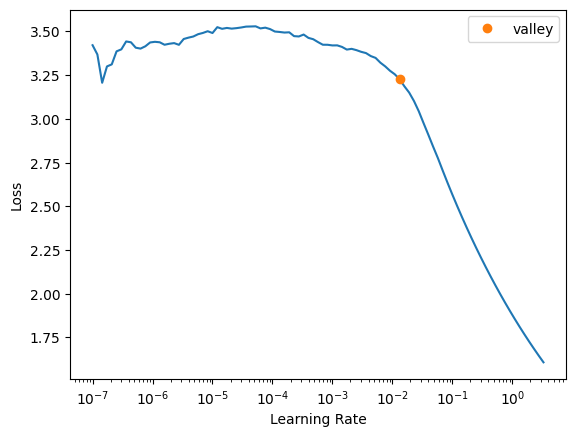

In [18]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

from pathlib import Path
from fastai.vision.all import *
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report, ConfusionMatrixDisplay

# 1. Semillas
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED) 
torch.cuda.manual_seed_all(SEED)

# 2. Parámetros
DATASET_PATH = Path('dataset_10_split_filtered')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 100
LR = 1e-3

# ===== CUDA CHECK =====
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

# 3. Definición de DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(IMG_SIZE, method='pad', pad_mode='zeros'),
    batch_tfms=aug_transforms(
        do_flip=True,
        max_rotate=10.0,
        max_zoom=1.2,
        max_warp=0.2,
        min_scale=0.8
    )
)

# 4. DataLoaders
dls = dblock.dataloaders(DATASET_PATH, bs=BATCH_SIZE, num_workers=0)

# 5. Cálculo de pesos de clase
train_ds = dls.train_ds
labels = [int(train_ds[i][1]) for i in range(len(train_ds))]
counts = np.bincount(labels)
inv_freq = 1.0 / (counts + 1e-6)
inv_freq /= inv_freq.sum()
sample_weights = [inv_freq[l] for l in labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# 6. Reemplazar el DataLoader de train
#    -> 'dls.loaders[0]' es el train_dl en la mayoría de versiones
train_dl = dls.loaders[0].new(shuffle=False, sampler=sampler)
dls.loaders[0] = train_dl
dls.cuda()

# 7. Definir Learner
learn = vision_learner(
    dls,
    arch=models.efficientnet_b5,
    metrics=[accuracy],
    loss_func=CrossEntropyLossFlat()
).to_fp16()

# 8. Buscar LR recomendado
lr_recommended = learn.lr_find().valley
print(f"Learning Rate recomendado: {lr_recommended}")

# 9. Entrenar
save_cb = SaveModelCallback(monitor='accuracy', fname='best_model_b5')
csv_cb  = CSVLogger(fname='training_log_b5.csv')

learn.fit_one_cycle(
    EPOCHS,
    lr_recommended,
    cbs=[save_cb, csv_cb]
)

learn.save('last_model_b5', with_opt=True)


In [ ]:

# ======================================
# 9. Evaluación en el set de TEST
# ======================================
test_files = get_image_files(DATASET_PATH / 'test')
test_ds = dblock.datasets.add_test(test_files)  # Agregar conjunto de test al DataBlock
test_dl = learn.dls.test_dl(test_files)

# Cargamos el mejor modelo antes de testear
learn.load('best_model_b5')

print("\n🔍 Evaluación en Test:")
test_loss, test_accuracy = learn.validate(dl=test_dl)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

# Predicciones en test
preds, targs = learn.get_preds(dl=test_dl)
pred_labels = preds.argmax(dim=1)

# ======================================
# 10. Métricas adicionales
# ======================================
# MAE (entre índices de clase). 
mae = mean_absolute_error(targs, pred_labels)
print(f"Mean Absolute Error (MAE) en test: {mae:.4f}")

# Matriz de confusión
cm = confusion_matrix(targs, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab.o2i.keys())
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Matriz de Confusión - Test')
plt.show()

print("\nReporte detallado:")
print(classification_report(targs, pred_labels, target_names=dls.vocab.o2i.keys()))

# ======================================
# 11. Gráficas de métricas
# ======================================
metrics = np.array(learn.recorder.values)

plt.figure(figsize=(12, 4))

# 11a. Gráfica de Accuracy
plt.subplot(1, 2, 1)
plt.plot(metrics[:,2], label='Train Accuracy')
plt.plot(metrics[:,3], label='Valid Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.title('Accuracy por Época')
plt.legend()

# 11b. Gráfica de Loss
plt.subplot(1, 2, 2)
plt.plot(metrics[:,0], label='Train Loss')
plt.plot(metrics[:,1], label='Valid Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss por Época')
plt.legend()

plt.show()
